Linux-6.2.0-26-generic-x86_64-with-glibc2.35
Esta conectado un GW,GDS-1072A-U,EM111924,V1.06

Escala:  0.2
Offset:  -0.008
Base de tiempo:  2.5e-05
Leidos 8014 datos
Escala:  0.05
Offset:  0.0
Base de tiempo:  2.5e-05
Leidos 8014 datos


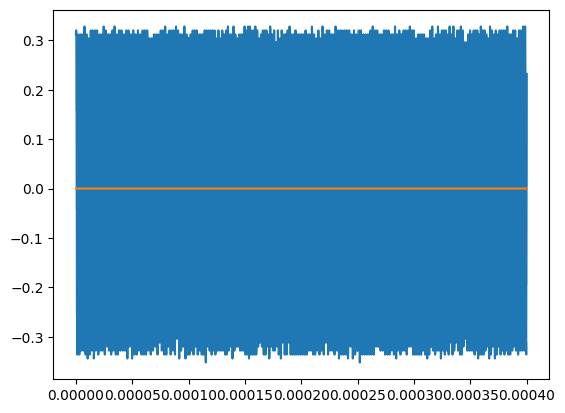

Escala:  0.2
Offset:  -0.008
Base de tiempo:  2.5e-05
Leidos 8014 datos
Vrms = 0.23433


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  1 09:57:19 2018

@author: Ramiro
"""

import numpy as np
# Traemos la libreria VISA
import pyvisa as visa
# Traemos matplotlib para poder graficar
import matplotlib.pyplot as plt

import scipy.signal as dsp
# Agreamos el path de las librerias
import sys
sys.path.insert(0, 'instrumentacion_virtual-master')
sys.path.insert(0, 'instrumentacion_virtual-master/InstVirtualLib')

import platform
# Traemos todos los osciloscopios
from InstVirtualLib.osciloscopios import GW_Instek
from InstVirtualLib.osciloscopios import rigol
from InstVirtualLib.osciloscopios import Tektronix_DSO_DPO_MSO_TDS
# Traemos el operador
import operador

# Definimos una funcion para poder ejecutar un mensaje de error
def excepthook(type, value, traceback):
    print(value)

sys.excepthook = excepthook



# Seteamos el tipo de osciloscio a utilizar
OSCILOSCOPIOS = 0	# 0: GW_Instek
			# 1: rigol
			# 2: Tektronix_DSO_DPO_MSO_TDS

USE_DEVICE = 0

# Abrimos el instrumento
platforma = platform.platform()
print(platforma)
rm=visa.ResourceManager()

instrument_handler=rm.open_resource(rm.list_resources()[USE_DEVICE])

if OSCILOSCOPIOS == 0:
	MiOsciloscopio = GW_Instek(instrument_handler)
elif OSCILOSCOPIOS == 1:
	MiOsciloscopio = rigol(instrument_handler)
elif OSCILOSCOPIOS == 2:
	MiOsciloscopio = Tektronix_DSO_DPO_MSO_TDS(instrument_handler)
else:
	raise ValueError('Tipo de osciloscopio fuera de lista.')


# Informamos el modelo del osciloscopio conectado
print("Esta conectado un %s"%MiOsciloscopio.INSTR_ID)


# Pedimos el trazo de cada canal, la salida es en ([seg.],[volt])
tiempo1,tension1=MiOsciloscopio.get_trace("1",VERBOSE=False)
tiempo2,tension2=MiOsciloscopio.get_trace("2",VERBOSE=False)

# Ploteamos los canales
plt.plot(tiempo1,tension1,tiempo2,tension2)
plt.show()

# Generamos un operador y pedimos el valor RMS actual
operador_1 = operador.Operador_osciloscopio(MiOsciloscopio,"Workbench_I")

val_RMS = operador_1.medir_Vrms(canal = 1, VERBOSE = False)

print('Vrms = %0.5f'%val_RMS)

MiOsciloscopio.close()

In [2]:
## AGREGADO:

def plot_spec(signal,fs,tipo="full",win="rect"):
    espec=20*np.log10(np.abs(np.fft.fft(signal))/len(signal))
    espec=np.fft.fftshift(espec)
    fcia=np.linspace(-fs/2,fs/2,len(signal))
    if tipo=="half":
        espec=espec[len(signal)//2:]
        fcia=fcia[len(signal)//2:]
    plt.figure()
    plt.title('Espectro de la señal')
    plt.ylim(np.max(espec)-75,np.max(espec)+5)
    plt.plot(fcia,espec)

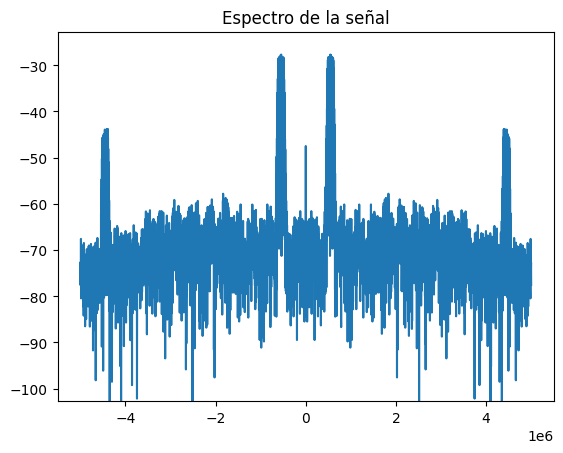

In [3]:
############################
### Parametros del DSO  ####
############################
fs = 1/(tiempo1[1]-tiempo1[0])

plot_spec(tension1, fs)

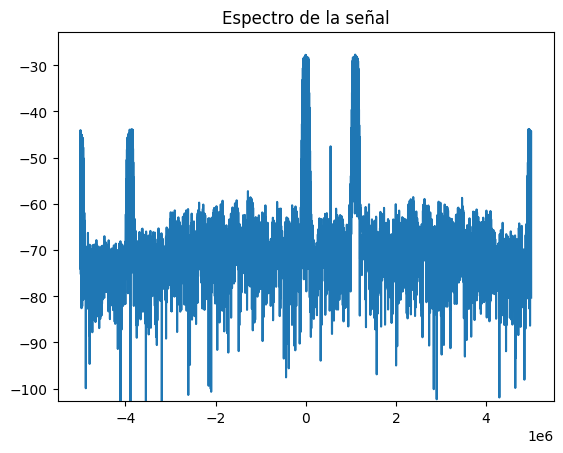

In [4]:
fc=550e3
tension1_sp=tension1*np.exp(1j*2*np.pi*fc*tiempo1)

plot_spec(tension1_sp, fs)

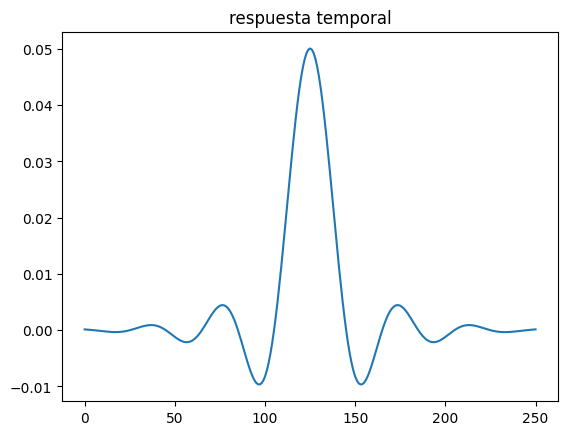

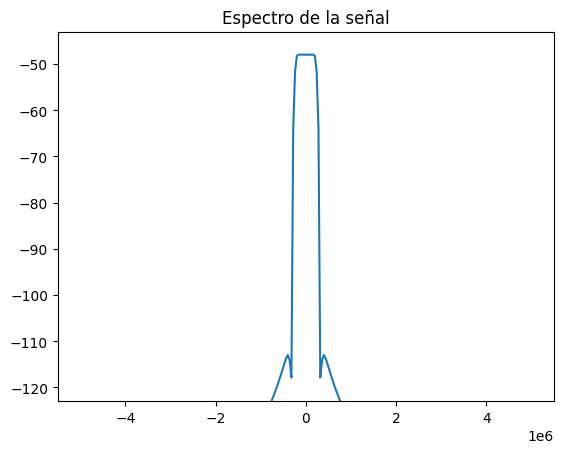

In [5]:
filtro=dsp.firwin(251,500e3/fs)
plt.title("respuesta temporal")
plt.plot(filtro) 
plot_spec(filtro,fs)

In [6]:
### demodulacion en cuadratura ####

def FM_demod (señal,fs):
    return np.angle(señal[:-1]*np.conjugate(señal[1:]))*fs/(2*np.pi)

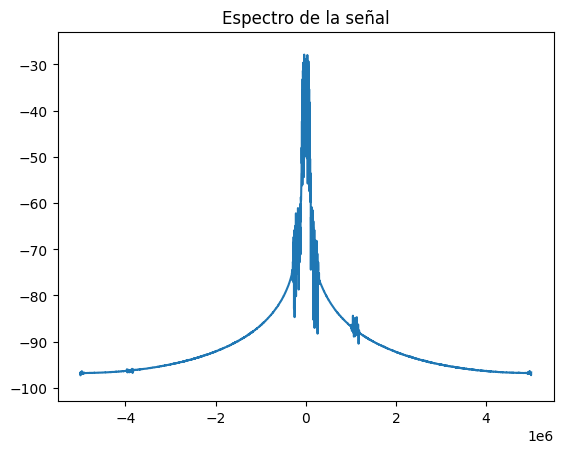

In [7]:
ComplexEnvelope_filt=np.convolve(filtro,tension1_sp,mode="valid")
plot_spec(ComplexEnvelope_filt,fs)

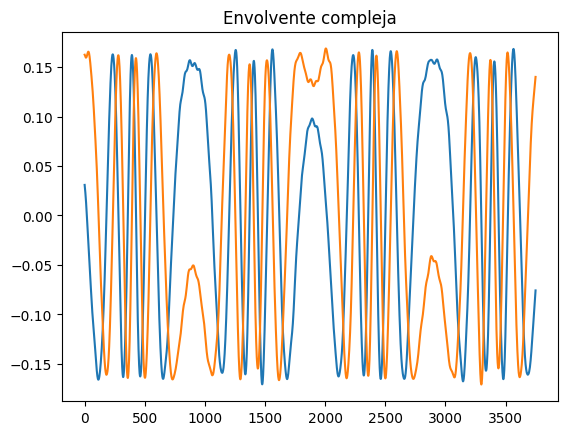

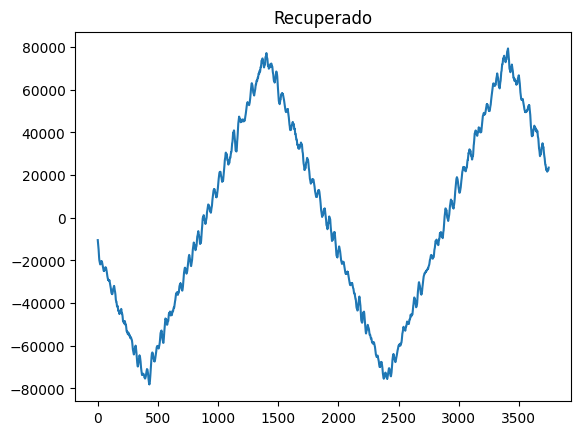

In [8]:
#plot_spec(ComplexEnvelope,fs)
#plot_spec(ComplexEnvelope_filt,fs)
plt.title("Envolvente compleja")
plt.plot(np.real(ComplexEnvelope_filt))
plt.plot(np.imag(ComplexEnvelope_filt))


demod= FM_demod(ComplexEnvelope_filt,fs)
plt.figure()
plt.title("Recuperado")
plt.plot(demod)